In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as mp
import numpy as np
import random

In [11]:
def log_returns(price_series,interval):
    return (np.log(price_series/
    price_series.shift(interval)))

def standardized_returns(returns):
    mu=np.mean(returns)
    sig = np.std(returns)
    return (returns-np.repeat(mu,len(returns)))/sig

def unstandardized_returns(returns, mu,sig):
    tmp = np.array(returns)*sig+mu 
    return [x if x> -1 else -0.99 for x in tmp]

def get_price_series(returns,p0):
    tmp=[]
    for j in range(0,len(returns)+1):
        if(j == 0):
            tmp.append(p0)
        else:
            tmp.append(tmp[-1]*np.exp(returns[j-1]))
    return tmp

In [3]:
def create_sample_path(returns, **kwargs):
    sample_length=kwargs.get('sample_length',10) #desired length of output sample 
    min_connected_original=kwargs.get('min_connected_original',1) #minimum amount of subsequent datapoints that are drawn together
    max_connected_original=kwargs.get('max_connected_original',1) #see above, but upper limit - should be interval where autocorrelation is insignificant
    with_replacement = kwargs.get('with_replacement',1) #draw with (1) or without (0) replacement from original sample

    length = 0
    sample_path=[]
    
    if (with_replacement==0) & (sample_length >= len(returns)):
        print('Cant do without replacement to achieve sample length, do with replacement')
        with_replacement = 1

    returns_copy = returns.copy() 
    while length < sample_length:
        this_length = random.randint(min_connected_original,max_connected_original)
        if length + this_length>sample_length:
            this_length = sample_length-length
            
        start = random.randint(1,len(returns_copy)-this_length)
        sample_path += returns_copy[start:start+this_length]
        if with_replacement==0:
            del returns_copy[start:start+this_length]
        length += this_length
    
    return sample_path

In [9]:
def make_df_price_simulation(series_returns,num_paths,sample_length, p0, **kwargs):
    #creates simulated pathes based on input timeseries
    #series_returns: input timeseries of log returns
    #num_paths: how many paths we want to simulate
    #sample_length: length of each path (in timesteps of input timeseries)
    #p0: initial price of simualated price series
    
    #mu_adjustment: factor which is multiplied with original drift of log-returns to adjust the drift of the simulated standardized returns (in case mu_adjustment!=1)
    #sigma_adjustment: factor which is multiplied with original drift of log-returns to adjust the drift of the simulated standardized returns (in case mu_adjustment!=1)
    #return_df: what format shall be returned: 
    #   just simulated price paths -> return_df='prices'
    #   just simulated log returns -> return_df='returns'
    #   just simulated standardized returns -> return_df='std_returns'
    #   all of the above dataframes (as dictionary) -> return_df='' (default)
    #min_connected: minimum length of timesteps (of input timeseries) that are drawn as block from initial series of returns (to preserve parts of the Autocorrelation of the input timeseries)
    #max_connected: same as above, but the max length of timesteps (should be interval where autocorrelation is insignificant). The actual  length of timesteps drawn together as block is a random integer (uniform) between min and max
    #with_replacement: draw with (1) or without (0) replacement from original sample

    
    mu_adjustment = kwargs.get('mu_adjustment',1)
    sigma_adjustment = kwargs.get('sigma_adjustment',1)
    return_df=kwargs.get('return_df','')
    min_connected=kwargs.get('min_connected',1)
    max_connected=kwargs.get('max_connected',3)
    with_replacement=kwargs.get('with_replacement',1)



    mu_orig=np.mean(series_returns)
    mu_sim = mu_orig*mu_adjustment
    sig_orig = np.std(series_returns)
    sig_sim = sig_orig*sigma_adjustment

    dct_prices={}
    dct_returns={}
    dct_std_returns={}

    
    series_std_returns=standardized_returns(series_returns)

    for j in range(num_paths):
        if ((j%int(num_paths/10))==0) & (j>0):
            print(str(round(j/num_paths*100,2)) + '% completed')
            
        sample_std_returns = create_sample_path(list(series_std_returns),
                                        sample_length = sample_length,
                                        min_connected_original = min_connected,
                                        max_connected_original = max_connected,
                                        with_replacement = with_replacement)
        sample_returns=unstandardized_returns(sample_std_returns,mu_sim,sig_sim)
        dct_returns[str(j)]=sample_returns
        dct_std_returns[str(j)]=sample_std_returns
        dct_prices[str(j)] = get_price_series(sample_returns,p0)

    df_prices=pd.DataFrame.from_dict(dct_prices)
    df_returns = pd.DataFrame.from_dict(dct_returns)
    df_std_returns =pd.DataFrame.from_dict(dct_std_returns) 

    if return_df =='prices':
        return df_prices
    elif return_df=='returns':
        return df_returns
    elif return_df=='std_returns':
        return df_std_returns
    else:
        return {'df_prices':df_prices,
            'df_returns':df_returns,
            'df_std_returns':df_std_returns}
    



## Step by step walkthrough (above can be copy/pasted into standalone script for simulations)
Everything needed for simulation is timeseries of log returns, see also notes in make_df_price_simulation

In [5]:
#basedata
eth = pd.read_csv('basedata/20211214_Binance_ETHUSDT_minute.csv')
eth.head()

,unix,date,symbol,open,high,low,close,Volume ETH,Volume USDT,tradecount
0,1639447560000,2021-12-14 02:06:00,ETH/USDT,3786.95,3786.96,3784.07,3785.75,33.3932,126403.264574,143
1,1639447500000,2021-12-14 02:05:00,ETH/USDT,3787.96,3788.12,3783.62,3786.96,136.9655,518539.662656,367
2,1639447440000,2021-12-14 02:04:00,ETH/USDT,3787.97,3789.53,3785.02,3788.12,230.0194,871130.040522,419
3,1639447380000,2021-12-14 02:03:00,ETH/USDT,3783.76,3789.02,3782.86,3787.96,181.2648,686384.940878,535
4,1639447320000,2021-12-14 02:02:00,ETH/USDT,3776.77,3783.77,3776.77,3783.76,170.0581,642879.523223,454


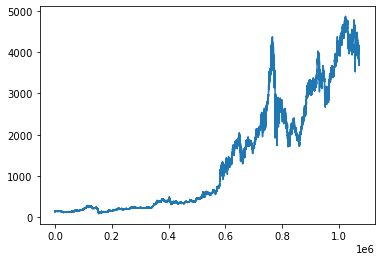

In [6]:
#reverse order
df_eth = eth.sort_values('date').reset_index()
mp.plot(df_eth.open)

In [7]:
eth_returns = log_returns(df_eth.open,1)
#everything beyond this is just looking at data/not needed for simulations

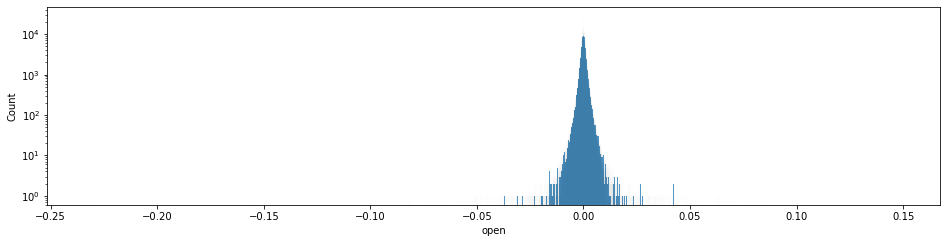

In [18]:

fig = mp.figure(figsize=(16,8))
ax = fig.add_subplot(2, 1, 1)
sns.histplot(eth_returns, ax=ax)
ax.set_yscale('log')


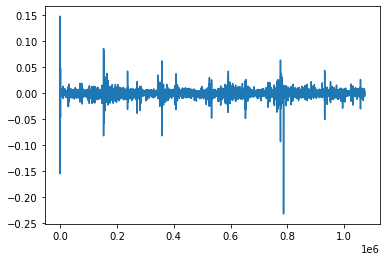

In [19]:
mp.plot(eth_returns)

In [20]:
eth_std_returns = standardized_returns(eth_returns)

3.038819909632956e-06
0.0015550443090251943


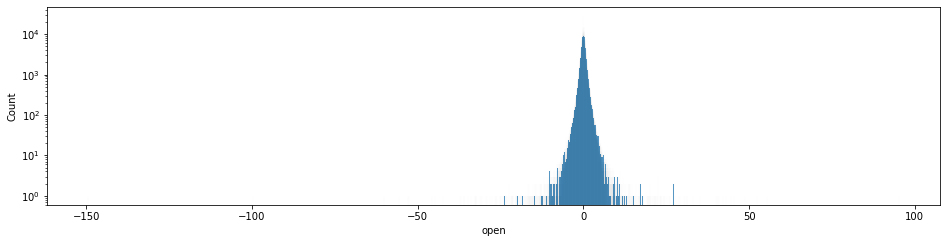

In [25]:
fig = mp.figure(figsize=(16,8))
ax = fig.add_subplot(2, 1, 1)
sns.histplot(eth_std_returns, ax=ax)
ax.set_yscale('log')


## Simulate paths

In [12]:
num_paths = 200
sample_length = 365*24*60
# len(eth_std_returns)-1
mu_orig=np.mean(eth_returns)
mu_adjustment = 1/10
sig_adjustment = 1

p0=4000

dct_out = make_df_price_simulation(eth_returns,num_paths,sample_length,p0,
                        mu_adjustment=mu_adjustment,
                        sigma_adjustment=sig_adjustment,
                        min_connected = 60,
                        max_connected = 60*24*3,
                        with_replacement=1)


df_prices = dct_out['df_prices']
df_returns = dct_out['df_returns']
df_std_returns = dct_out['df_std_returns']

10.0% completed
20.0% completed
30.0% completed
40.0% completed
50.0% completed
60.0% completed
70.0% completed
80.0% completed
90.0% completed


# look into distributions

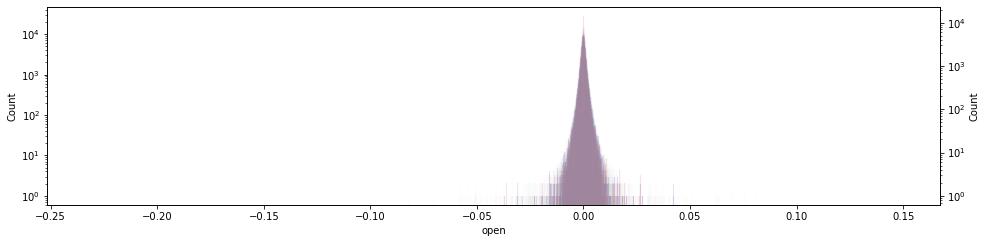

In [61]:
fig = mp.figure(figsize=(16,8))
ax = fig.add_subplot(2, 1, 1)
ax2=ax.twinx()
sns.histplot(eth_returns, ax=ax, color='b',alpha=0.1)
for pos in random_positions_check:
    sns.histplot(df_returns[pos], ax=ax2, color='r',alpha=0.1)
ax.set_yscale('log')
ax2.set_yscale('log')


Text(0.5, 1.0, 'ETH price next ~1.0y, with 0.1x original drift and 1x original volatility')

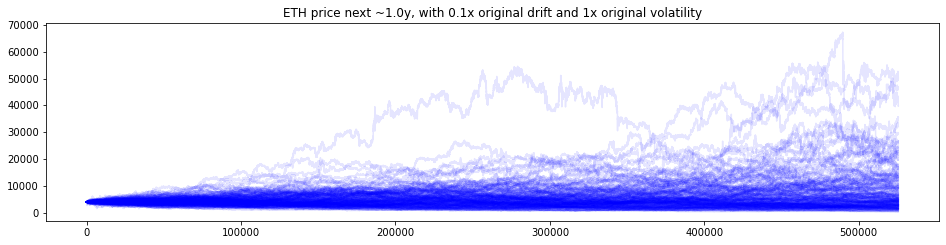

In [17]:
fig = mp.figure(figsize=(16,8))
ax = fig.add_subplot(2, 1, 1)
sample_length_years = sample_length/60/24/365 #hardcoded, please adjust according to interval length

ax.plot(df_prices, color='b',alpha=0.1)
# ax.set_yscale('log')
# ax.set_ylim(0,200000)
title_str = 'ETH price next ~' + str(round(sample_length_years,1))+ 'y, with '
title_str += str(round(mu_adjustment,1)) + 'x original drift and '                                     
title_str += str(round(sig_adjustment,1)) + 'x original volatility'                                                      
ax.set_title(title_str)

Text(0.5, 1.0, 'Percentiles of ETH price next ~1.0y, with 0.1x original drift and 1x original volatility \n(red=median, blue=quartiles, gray=10/90 and 5/95 (light gray) quantiles)')

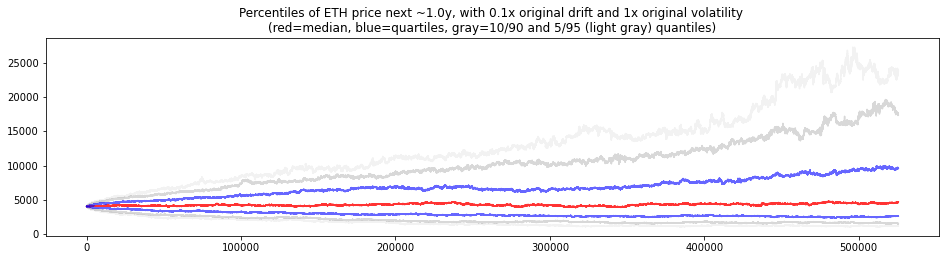

In [21]:
fig = mp.figure(figsize=(16,8))
ax = fig.add_subplot(2, 1, 1)
df_chart=df_prices
sample_length_years = sample_length/60/24/365 #hardcoded, please adjust according to interval length

ax.plot([np.percentile(df_chart.iloc[i],95) for i in range(0,len(df_chart))], color='gray',alpha=0.1)
ax.plot([np.percentile(df_chart.iloc[i],5) for i in range(0,len(df_chart))], color='gray',alpha=0.1)
ax.plot([np.percentile(df_chart.iloc[i],90) for i in range(0,len(df_chart))], color='gray',alpha=0.3)
ax.plot([np.percentile(df_chart.iloc[i],10) for i in range(0,len(df_chart))], color='gray',alpha=0.3)
ax.plot([np.percentile(df_chart.iloc[i],50) for i in range(0,len(df_chart))], color='red',alpha=0.8)
ax.plot([np.percentile(df_chart.iloc[i],25) for i in range(0,len(df_chart))], color='blue',alpha=0.6)
ax.plot([np.percentile(df_chart.iloc[i],75) for i in range(0,len(df_chart))], color='blue',alpha=0.6)
# ax.set_yscale('log')
# ax.set_ylim(0,200000)
title_str = 'Percentiles of ETH price next ~' + str(round(sample_length_years,1))+ 'y, with '
title_str += str(round(mu_adjustment,1)) + 'x original drift and '                                     
title_str += str(round(sig_adjustment,1)) + 'x original volatility \n'
title_str += '(red=median, blue=quartiles, gray=10/90 and 5/95 (light gray) quantiles)'                                                     
ax.set_title(title_str)


### export to file if needed in other notebooks etc

In [63]:
df_prices.to_pickle('output/df_prices.pkl')